**Import Packages**

In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt


1. Load The Data From The Tensorflow Datsets

In [78]:
(x_train,y_train),(x_test,y_test) = tf.keras.datasets.cifar10.load_data()

170508288/170498071 [==============================] - 11s 0us/step


Cifar10 Dataset contain 60000 (32 32)  RGB images across 10 classes, the dataset is splitted in the following ways

train data = (50000,32,32,3)
test data = (10000,32,32,3)

lets makes sure everything is okay

In [79]:
assert (x_train.shape == (50000, 32, 32, 3))
assert (y_train.shape == (50000, 1) )

assert (x_test.shape == (10000, 32, 32, 3))
assert (y_test.shape == (10000, 1) )

Since our target label is integer encoded ie every class is assigned a number 
eg cat - 3 , dog - 5 , frog - 6. 

we convert them to one hot encoded vector. the vector will be of size 10 (since we have 10 classes) 

so if we are encoding number 3 it will become like this 

[0 0 0 1 0 0 0 0 0 0 ]

The index 3 is of cat that is why it is 1 (hot) and all are zero 

In [82]:
def to_one_hot(Y, C):

    Y = np.eye(C)[Y.reshape(-1)].T

    return Y

Here we will normalize the image by diving the image by 255 (max value in the image) this causes our image to have range between [0,1] . it will make our leraning faster(converge to the local minima)

  we are also reshapeing the RGB images into a one dimensional vector since input to the fully connected neural network is vector

  (32 32 3) -- (3072,)

In [83]:
def normalize(img) :

  ''' take an image as input convert it into a tensor'''

  img_t = (img) /255.0
  img_r = np.reshape(img_t,(img_t.shape[0],-1))

  return img_r

In [84]:
X_train_scaled = normalize(x_train)
X_test_scaled = normalize(x_test)

In [89]:
y_train_encoded = to_one_hot(y_train,10).T
y_test_encoded = to_one_hot(y_test,10).T

Although tensorflow suppprt numpy arrays it is best if we convert are data into tensor object . 


  For large dataset it is alaways advisable to use tf.data api for ETL(extract transform and load) . 

In [90]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_scaled,y_train_encoded))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test_scaled,y_test_encoded))

Tensor object has shape of (3072,) and data type is float 32

In [91]:
train_dataset.element_spec
test_dataset.element_spec

(TensorSpec(shape=(3072,), dtype=tf.float64, name=None),
 TensorSpec(shape=(10,), dtype=tf.float64, name=None))

Lets visualize our dataset before we build our model

In [116]:
def plot_images(X,categories) :

  #since tf data returns a generator 
  # we use iter method on the data so we can iterate over them easily
  images = iter(X)

  plt.figure(figsize=(10, 10))

  height = 5
  width = 5

  for i in range(height * width):

    ax = plt.subplot(height,width , i + 1)
    img,label = next(images)
    img = img.numpy().reshape(32,32,3)
    plt.title(categories[label.numpy().argmax()])
    plt.imshow(img,cmap='gray')
    plt.axis("off")



In [115]:
categories = {0:'Airplane',1:'Automobile',2:'Bird',3:'Cat',4:'Deer',5:'Dog',6:'Frog',7:'Horse',8:'Ship',9:'Truck'}
categories

{0: 'Airplane',
 1: 'Automobile',
 2: 'Bird',
 3: 'Cat',
 4: 'Deer',
 5: 'Dog',
 6: 'Frog',
 7: 'Horse',
 8: 'Ship',
 9: 'Truck'}

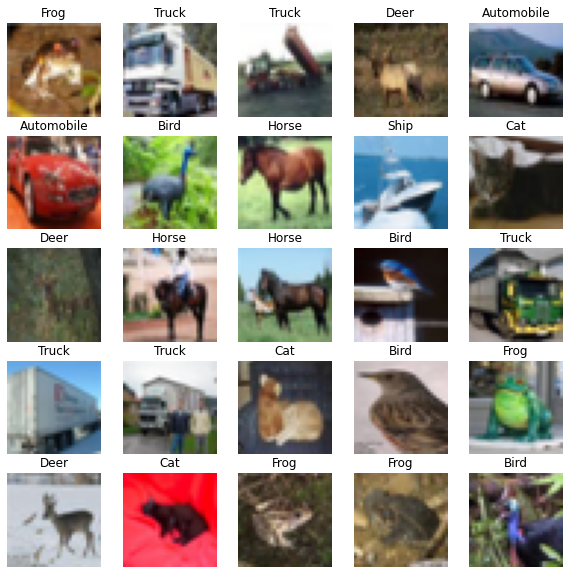

In [117]:
plot_images(train_dataset,categories)

In [96]:
INPUT_DIM = next(iter(train_dataset))[0].numpy().shape[0]

In [97]:
print(INPUT_DIM)

3072


Building Model in tensorflow(or any other deep learning frameworks) is really easiar since we only need to stack them one by one

  Deep learning is a iterative process we have experiment with diffrent architectures and try different things untill we find our desired model.

We will be using keras functional api to define our model. our model following the following pattern

INPUT --> Dense -- > Dense --> Dense - Softmax


In [109]:

def Model() :


  input = tf.keras.layers.Input(shape=INPUT_DIM)

  x = tf.keras.layers.Dense(units=1024,activation='relu')(input)
  x = tf.keras.layers.Dense(units=1024,activation='relu')(x)
  x = tf.keras.layers.Dense(units=512,activation='relu')(x)
  output = tf.keras.layers.Dense(units=10,activation='softmax')(x)

  model = tf.keras.Model(input,output)

  return model

In [110]:
model = Model()

In [111]:
model.summary()

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 3072)]            0         
                                                                 
 dense_42 (Dense)            (None, 1024)              3146752   
                                                                 
 dense_43 (Dense)            (None, 1024)              1049600   
                                                                 
 dense_44 (Dense)            (None, 512)               524800    
                                                                 
 dense_45 (Dense)            (None, 10)                5130      
                                                                 
Total params: 4,726,282
Trainable params: 4,726,282
Non-trainable params: 0
_________________________________________________________________


Now with everything set , we are ready to train our model .
we will train our model with batch size 2048 (larger batch size since we have large dataset) .

Optimizer `adam` works really well for deep learning task so wi will be using it. loss function is `categorycal crossentropy`

and train the neural network 100 `epoch`

In [112]:
def train_model(model,dataset_train,dataset_test,epoch=10) :

  dataset_train = dataset_train.batch(2048)
  dataset_test = dataset_test.batch(1024)


  optimizer = tf.keras.optimizers.Adam()

  model.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])

  history = model.fit(dataset_train,epochs=epoch,verbose=1,validation_data=dataset_test)

  return history

In [113]:
history = train_model(model,train_dataset,test_dataset,epoch=100)

Epoch 1/100
25/25 [==============================] - 3s 84ms/step - loss: 2.4382 - accuracy: 0.1677 - val_loss: 2.0221 - val_accuracy: 0.2591
Epoch 2/100
25/25 [==============================] - 2s 77ms/step - loss: 1.9411 - accuracy: 0.3017 - val_loss: 1.8604 - val_accuracy: 0.3350
Epoch 3/100
25/25 [==============================] - 2s 78ms/step - loss: 1.8196 - accuracy: 0.3508 - val_loss: 1.7633 - val_accuracy: 0.3673
Epoch 4/100
25/25 [==============================] - 2s 77ms/step - loss: 1.7390 - accuracy: 0.3784 - val_loss: 1.7107 - val_accuracy: 0.3821
Epoch 5/100
25/25 [==============================] - 2s 76ms/step - loss: 1.6786 - accuracy: 0.3993 - val_loss: 1.6531 - val_accuracy: 0.4096
Epoch 6/100
25/25 [==============================] - 2s 76ms/step - loss: 1.6354 - accuracy: 0.4164 - val_loss: 1.6219 - val_accuracy: 0.4215
Epoch 7/100
25/25 [==============================] - 2s 75ms/step - loss: 1.5900 - accuracy: 0.4338 - val_loss: 1.5845 - val_accuracy: 0.4427
Epoch 

In [118]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [124]:
def plot_history(history) :


  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Train accuracy vs Validation Accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Train loss Vs val loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

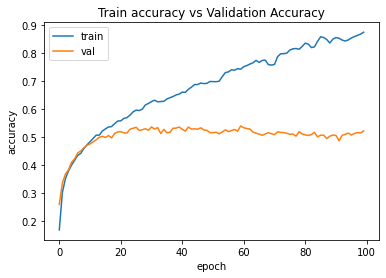

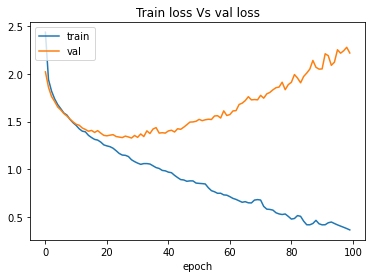

In [125]:
plot_history(history)

We can see from the above graph that our traininig performance increase as with each epoch and loss decreses. But our validation data performance plateu after certain epoch, that is because fully connected neural network has too many parameters and it is prone to overfitting. fully connected neural network does perform well on image data since it is looking at each for classification and not on the features.

  Convolutional neural network is type of artifical nrural network that performs really well on image data it combines Artificial neural netorks with kernel convolution . 